# Clasificación de Texto Usando Embeddings Pre-entrenados

Este notebook realiza la clasificación de texto para identificar al autor de un texto entre tres autores posibles, utilizando embeddings pre-entrenados de GloVe y redes neuronales feed-forward (FFNN). Procesa los datos de texto, entrena múltiples arquitecturas de redes neuronales y evalúa su rendimiento en base a la precisión, exactitud y recall.

## 0. Importación de Librerias y Embeddings

In [1]:
import requests
import zipfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras import (
    utils,
    layers,
    models,
    callbacks
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Cargar los embeddings pre-entrenados de Glove
glove_download_url = "https://nlp.stanford.edu/data/glove.6B.zip"
response = requests.get(glove_download_url)

def load_embeddings(dim: int) -> dict[str, np.ndarray[float]]:
    """
    Carga los embeddings pre-entrenados de Glove y los devuelve en un diccionario.
    
    Args:
        dim (int): Dimensión de los embeddings a cargar
    
    Returns:
        dict[str, np.ndarray[float]]: Diccionario con los embeddings cargados
    """
    glove_zip_path = "glove.6B.zip"
    glove_path = f'glove.6B.{dim}d.txt'

    with open(glove_zip_path, 'wb') as file:
        file.write(response.content)

    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extract(glove_path, "data/models/glove/")

    embeddings_index = {}

    with open(os.path.join("data/models/glove/", glove_path), 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [3]:
# Cargar el dataset
df = pd.read_csv('data/classifier/sentences.csv')
df.head()

,author,sentence
0,Jane Austen,The family of Dashwood had long been settled i...
1,Jane Austen,"The old gentleman died: his will was read, and..."
2,Jane Austen,"No sooner was his father’s funeral over, than ..."
3,Jane Austen,"“Certainly not; but if you observe, people alw..."
4,Jane Austen,Edward Ferrars was not recommended to their go...


In [4]:
# Contar el número de datos por autor
author_counts = df['author'].value_counts()

# Crear DataFrame resumen
summary_df = author_counts.reset_index()
summary_df.columns = ['author', 'num_training_data']

summary_df

,author,num_training_data
0,Leo Tolstoy,866
1,Jane Austen,426
2,James Joyce,321


## 1. Preprocesamiento de los Datos

In [5]:
# Dividir el dataframe en conjuntos de entrenamiento, prueba y validación
train_df, temp_df = train_test_split(df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)

x_train, y_train = train_df['sentence'], train_df['author']
x_val, y_val = val_df['sentence'], val_df['author']
x_test, y_test = test_df['sentence'], test_df['author']

In [6]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1
max_length = 250

# Preparación de los datos de entrenamiento y validación
sequences = tokenizer.texts_to_sequences(x_train)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

val_x_data = tokenizer.texts_to_sequences(x_val)
val_padded_sequences = pad_sequences(val_x_data, maxlen=max_length, padding='post', truncating='post')

# Preparación de las etiquetas
labelEncoder = LabelEncoder()
y_train_encoded = utils.to_categorical(labelEncoder.fit_transform(y_train), num_classes=3)
y_val_encoded = utils.to_categorical(labelEncoder.transform(y_val), num_classes=3)

## 2. Definición de los Modelos

In [7]:
def init_model(embeddings_index: dict[str, np.ndarray[float]], embedding_dim: int, architecture_type: int):
    """
    Inicializa un modelo de red neuronal feedforward basado en el tipo de arquitectura elegida.
    
    Args:
        embeddings_index (dict[str, np.ndarray[float]]): Diccionario con los embeddings pre-entrenados.
        embedding_dim (int): Dimensión de los embeddings.
        architecture_type (int): Tipo de arquitectura (1, 2, o 3).
        
    Returns:
        models.Sequential: Modelo de red neuronal inicializado con la arquitectura seleccionada.
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = layers.Embedding(vocab_size, embedding_dim, trainable=False)
    embedding_layer.build((1,))
    embedding_layer.set_weights([embedding_matrix])

    if architecture_type == 1:
        # Modelo 1: Simple
        model = models.Sequential([
            layers.Input(shape=(max_length,)),
            embedding_layer,
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(3, activation='softmax')
        ])
    
    elif architecture_type == 2:
        # Modelo 2: Más profundo con más capas densas
        model = models.Sequential([
            layers.Input(shape=(max_length,)),
            embedding_layer,
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(3, activation='softmax')
        ])
    
    elif architecture_type == 3:
        # Modelo 3: Más profundo con más capas y unidades
        model = models.Sequential([
            layers.Input(shape=(max_length,)),
            embedding_layer,
            layers.Flatten(),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dense(3, activation='softmax')
        ])
    
    else:
        raise ValueError("El tipo de arquitectura debe ser 1, 2 o 3.")
    
    return model

## 3. Entrenamiento y Evaluación de los Modelos

In [8]:
def eval_model(model):
    """
    Evalua el modelo de clasificación

    Args:
        model (models.Sequential): Modelo a evaluar

    Returns:
        None
    """
    # Preprocesar x_test
    test_sequences = tokenizer.texts_to_sequences(x_test)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    # Hacer las predicciones
    predictions = model.predict(test_padded_sequences)
    predicted_classes = np.argmax(predictions, axis=1)

    # Codificar y_test
    y_test_encoded = labelEncoder.transform(y_test)

    # Generar reporte de clasificación, usando zero_division=0 para evitar advertencias y ajustar precisión indefinida a 0
    report = classification_report(y_test_encoded, predicted_classes, target_names=labelEncoder.classes_, zero_division=0)

    print(report)

def plot_history(history):
    """
    Grafica la historia de entrenamiento del modelo

    Args:
        history (tensorflow.python.keras.callbacks.History): Historia de entrenamiento
    """
    # Visualizar la curva de aprendizaje
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Entrenando el Modelo 1 con embeddings de 50 dimensiones...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           851050    
                                                                 
 flatten (Flatten)           (None, 12500)             0         
                                                                 
 dense (Dense)               (None, 512)               6400512   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 7,253,101
Trainable params: 6,402,051
Non-trainable params: 851,050
_____________________________________________

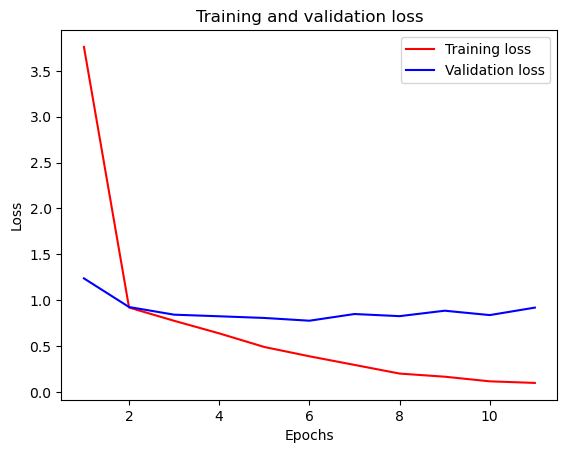

8/8 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

 James Joyce       0.73      0.20      0.31        41
 Jane Austen       0.88      0.38      0.53        76
 Leo Tolstoy       0.60      0.94      0.73       125

    accuracy                           0.64       242
   macro avg       0.73      0.51      0.52       242
weighted avg       0.71      0.64      0.60       242


Entrenando el Modelo 2 con embeddings de 50 dimensiones...

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 50)           851050    
                                                                 
 flatten_1 (Flatten)         (None, 12500)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               3200256   
                       

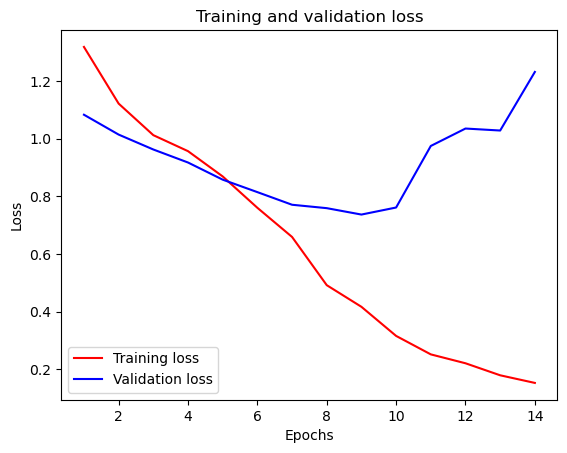

8/8 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

 James Joyce       0.80      0.20      0.31        41
 Jane Austen       0.87      0.53      0.66        76
 Leo Tolstoy       0.63      0.94      0.76       125

    accuracy                           0.69       242
   macro avg       0.77      0.56      0.58       242
weighted avg       0.74      0.69      0.65       242


Entrenando el Modelo 3 con embeddings de 50 dimensiones...

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 50)           851050    
                                                                 
 flatten_2 (Flatten)         (None, 12500)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               6400512   
                       

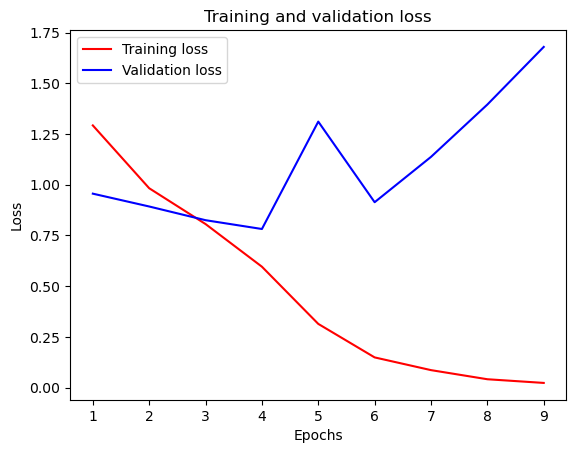

8/8 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

 James Joyce       0.80      0.29      0.43        41
 Jane Austen       0.89      0.43      0.58        76
 Leo Tolstoy       0.63      0.95      0.76       125

    accuracy                           0.68       242
   macro avg       0.77      0.56      0.59       242
weighted avg       0.74      0.68      0.65       242


Entrenando el Modelo 1 con embeddings de 100 dimensiones...

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          1702100   
                                                                 
 flatten_3 (Flatten)         (None, 25000)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               12800512  
                      

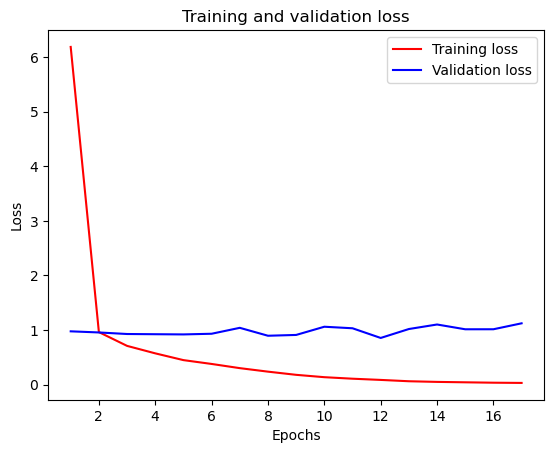

8/8 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

 James Joyce       0.88      0.17      0.29        41
 Jane Austen       0.88      0.58      0.70        76
 Leo Tolstoy       0.64      0.94      0.76       125

    accuracy                           0.70       242
   macro avg       0.80      0.56      0.58       242
weighted avg       0.76      0.70      0.66       242


Entrenando el Modelo 2 con embeddings de 100 dimensiones...

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 250, 100)          1702100   
                                                                 
 flatten_4 (Flatten)         (None, 25000)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               6400256   
                      

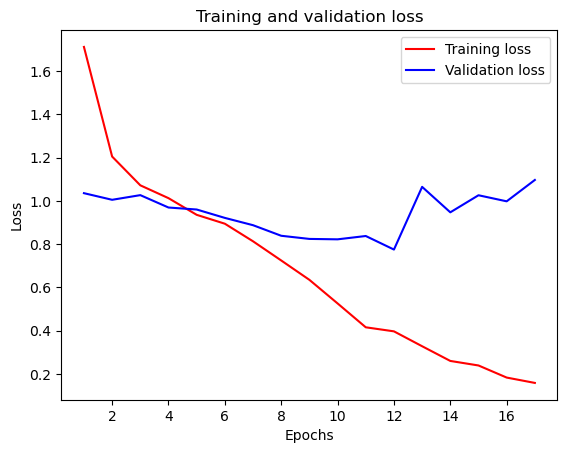

8/8 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

 James Joyce       1.00      0.15      0.26        41
 Jane Austen       0.92      0.58      0.71        76
 Leo Tolstoy       0.64      0.97      0.77       125

    accuracy                           0.71       242
   macro avg       0.85      0.56      0.58       242
weighted avg       0.79      0.71      0.67       242


Entrenando el Modelo 3 con embeddings de 100 dimensiones...

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 100)          1702100   
                                                                 
 flatten_5 (Flatten)         (None, 25000)             0         
                                                                 
 dense_17 (Dense)            (None, 512)               12800512  
                      

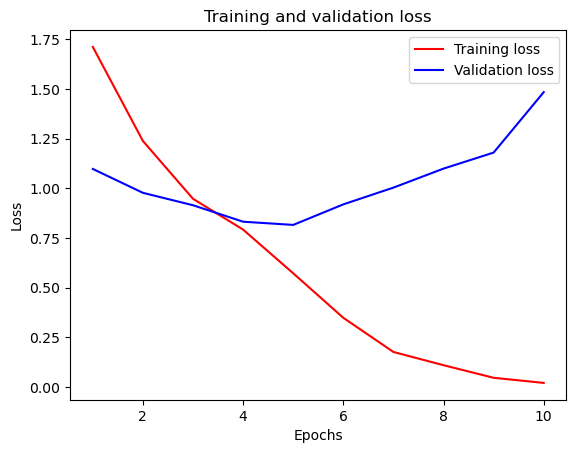

8/8 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

 James Joyce       0.52      0.27      0.35        41
 Jane Austen       0.91      0.38      0.54        76
 Leo Tolstoy       0.60      0.91      0.73       125

    accuracy                           0.64       242
   macro avg       0.68      0.52      0.54       242
weighted avg       0.68      0.64      0.60       242


Entrenando el Modelo 1 con embeddings de 300 dimensiones...

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 250, 300)          5106300   
                                                                 
 flatten_6 (Flatten)         (None, 75000)             0         
                                                                 
 dense_22 (Dense)            (None, 512)               38400512  
                      

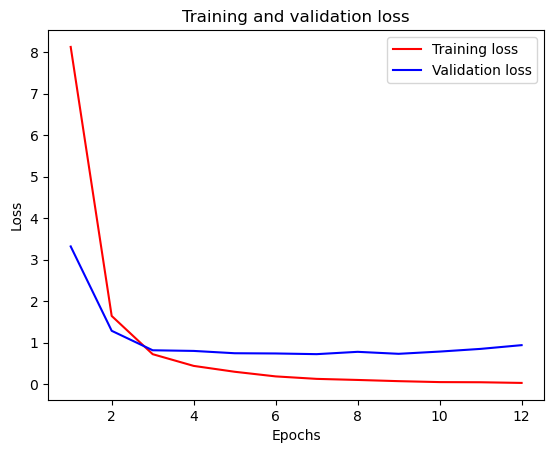

8/8 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

 James Joyce       0.78      0.17      0.28        41
 Jane Austen       1.00      0.45      0.62        76
 Leo Tolstoy       0.62      0.98      0.76       125

    accuracy                           0.68       242
   macro avg       0.80      0.53      0.55       242
weighted avg       0.77      0.68      0.63       242


Entrenando el Modelo 2 con embeddings de 300 dimensiones...

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 250, 300)          5106300   
                                                                 
 flatten_7 (Flatten)         (None, 75000)             0         
                                                                 
 dense_24 (Dense)            (None, 256)               19200256  
                     

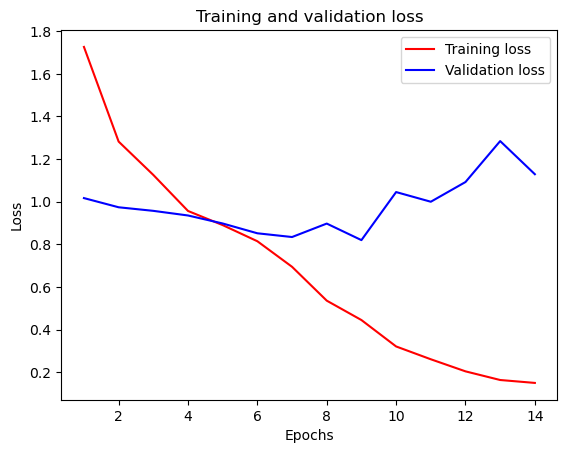

8/8 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

 James Joyce       0.78      0.17      0.28        41
 Jane Austen       0.97      0.46      0.62        76
 Leo Tolstoy       0.62      0.98      0.76       125

    accuracy                           0.68       242
   macro avg       0.79      0.54      0.56       242
weighted avg       0.76      0.68      0.64       242


Entrenando el Modelo 3 con embeddings de 300 dimensiones...

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 250, 300)          5106300   
                                                                 
 flatten_8 (Flatten)         (None, 75000)             0         
                                                                 
 dense_28 (Dense)            (None, 512)               38400512  
                     

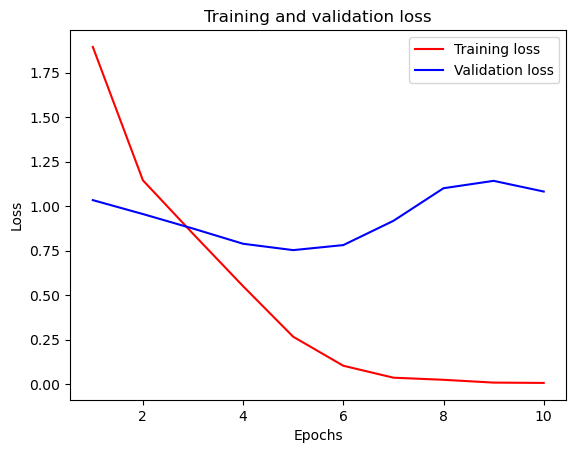

8/8 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

 James Joyce       0.65      0.37      0.47        41
 Jane Austen       0.88      0.76      0.82        76
 Leo Tolstoy       0.73      0.89      0.80       125

    accuracy                           0.76       242
   macro avg       0.75      0.67      0.69       242
weighted avg       0.76      0.76      0.75       242



In [9]:
# Entrenar y evaluar cada modelo con embeddings de 50D, 100D, 300D
for embedding_dim in [50, 100, 300]:
    embeddings_index = load_embeddings(embedding_dim)

    for architecture_type in [1, 2, 3]:
        print(f"\nEntrenando el Modelo {architecture_type} con embeddings de {embedding_dim} dimensiones...\n")
        
        # Inicializar el modelo usando la arquitectura correspondiente
        model = init_model(embeddings_index, embedding_dim, architecture_type)
        model.summary()

        # Compilar y entrenar
        model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        history = model.fit(
            padded_sequences, 
            y_train_encoded, 
            epochs=20, 
            batch_size=128, 
            validation_data=(val_padded_sequences, y_val_encoded),
            callbacks=[callbacks.EarlyStopping(patience=5, monitor="val_loss")]
        )

        # Graficar la curva de aprendizaje
        plot_history(history)

        # Evaluar el modelo
        eval_model(model)